## Intro

This is an example notebook of my workflow in categorizing students into different groups based on their behaviour on an exam. The dataset is mock data, also generated by me, but based on real life exam data I worked on in a previous project. 300 assumpted students took an electric Python exam. The exam had 10 questions and each student could retry the questions as many times as possible. Each questions was worth 100 points, and in the end, the score from the best try was used to calculate the final score. 

**Purpose:** showcase skills with data ETL, EDA, unsuperviced learning and behaviour classification.

**Inputs:**  
 - exam_data.csv - contains each submission per student and question with the score and how many seconds did the student spend on that task.
 - student_data.csv - contains more information about each student, age, gender and how many years do they have with Python.

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.style.use('seaborn-v0_8-ticks')

## Loading the data

In [2]:
# Load exam data. time_on_task is in seconds
exam_data = pd.read_csv("data/02 - Unsuperviced Learning/unsuperviced_learning_exam_data.csv")
exam_data.rename(columns={"time_on_task" : "time_on_task_in_seconds"}, inplace=True) # renaming column so that units won't be forgotten
exam_data

,student_id,question_id,score,time_on_task_in_seconds
0,3201,1,49,124
1,3201,1,100,96
2,3201,1,62,70
3,3201,2,87,22
4,3201,3,70,228
...,...,...,...,...
12030,1649,9,21,212
12031,1649,10,58,280
12032,1649,10,48,511
12033,1649,10,42,127


In [3]:
#Number of tries per task per student = Number of task submissions / number of questions / number of students
print(12498  / 10 / 300)

4.1659999999999995


In [4]:
# or with the following formula if we don't trust the intro description
print( len(exam_data) / len(exam_data.question_id.unique()) / len(exam_data.student_id.unique()))

4.011666666666667


In [5]:
exam_data.describe()

,student_id,question_id,score,time_on_task_in_seconds
count,12035.000000,12035.000000,12035.000000,12035.000000
mean,5463.890569,5.459659,61.894225,202.278521
std,2679.746491,2.855229,24.045194,109.842497
min,1025.000000,1.000000,0.000000,8.000000
25%,3059.000000,3.000000,45.000000,117.000000
50%,5401.000000,5.000000,63.000000,186.000000
75%,7896.000000,8.000000,80.000000,270.000000
max,9991.000000,10.000000,100.000000,600.000000


We can right away see some interesting statistics about the data:
 - Student IDs seem to be between 1000 and 9999 (probably not relevant)
 - Average question ID is 5.5, which means students tried the latter half of the exams questions slightly more often
 - Average score is 62, and ranges from 0 to 100. Standard deviation is 24, so most students probably did ok and passed.
 - Students spend on average 202s or 3 minutes and  22 seconds on each task. Max time on task was 10 minutes, which probably was an upper limit.

In [6]:
# Checking for NaNs
exam_data.isna().sum()

student_id                 0
question_id                0
score                      0
time_on_task_in_seconds    0
dtype: int64

In [7]:
# Load student data. gender is male if 0, female if 1
student_data = pd.read_csv("data/02 - Unsuperviced Learning/unsuperviced_learning_student_data.csv")
# renaming column so that gender mapping won't be forgotten. Also just in case add _in_years to age.
student_data.rename(columns={"gender":"female", "age":"age_in_years"},inplace=True) 
student_data

,student_id,female,age_in_years,python_experience_in_years
0,3201,0,25,4
1,2033,1,19,3
2,5179,0,25,4
3,2931,0,23,2
4,9117,0,19,2
...,...,...,...,...
295,8815,1,24,2
296,6152,1,23,2
297,2640,0,26,4
298,4401,1,19,4


In [8]:
student_data.describe()

,student_id,female,age_in_years,python_experience_in_years
count,300.000000,300.000000,300.000000,300.000000
mean,5506.913333,0.520000,22.893333,2.256667
std,2679.087636,0.500435,2.934392,0.916655
min,1025.000000,0.000000,18.000000,1.000000
25%,3131.250000,0.000000,20.000000,2.000000
50%,5406.000000,1.000000,23.000000,2.000000
75%,7837.500000,1.000000,25.250000,3.000000
max,9991.000000,1.000000,27.000000,4.000000


Observations from student data:
 - 300 students like mentioned
 - Almost 50/50 males and females
 - Average age is 22, and ranges between 18 and 27, so this is probably a university-level course?
 - On average, students had 2.3 years of Python experience. However, some had 1, some had 4. Since no one had 0, this might be a follow-up course.

In [9]:
# Checking for NaNs
student_data.isna().sum()

student_id                    0
female                        0
age_in_years                  0
python_experience_in_years    0
dtype: int64

## Initial thoughts
Since there is variation in the scores, time_on_task, gender, age and Python experience, students probably behaved differently and had different kinds of skills. Therefore, it is likely that they could be separated into N different groups based on their behaviour. However, in order to extract more information from this data, we can do some feature engineering and also check whether all features have impact on the results.

## Feature engineering
Next, let's merge the data and calculate statistics per question and then per student.

In [10]:
# Merge the student information to the exam data. 
# Since both have "student_id" column, the merge function doesn't need extra arguments.
exam_data_full = exam_data.merge(student_data)
exam_data_full

,student_id,question_id,score,time_on_task_in_seconds,female,age_in_years,python_experience_in_years
0,3201,1,49,124,0,25,4
1,3201,1,100,96,0,25,4
2,3201,1,62,70,0,25,4
3,3201,2,87,22,0,25,4
4,3201,3,70,228,0,25,4
...,...,...,...,...,...,...,...
12030,1649,9,21,212,1,20,3
12031,1649,10,58,280,1,20,3
12032,1649,10,48,511,1,20,3
12033,1649,10,42,127,1,20,3


In [11]:
%%time
# Let's transform the data, calculate statistics per question 
# From the grouped data, we can calculate the number of tries per question,
# max and mean scores, and how long time on average it took per try
grouped_pd = exam_data_full.groupby(["student_id","question_id"])
data_pq= pd.DataFrame()

data_pq[["female","age_in_years","python_experience_in_years"]] = grouped_pd[["female","age_in_years","python_experience_in_years"]].first()
data_pq["tries"] = grouped_pd["question_id"].size()
data_pq["score_max"] = grouped_pd["score"].max()
data_pq["score_mean"] = grouped_pd["score"].mean()
data_pq["time_per_try_in_seconds"] = grouped_pd["time_on_task_in_seconds"].sum() / grouped_pd["time_on_task_in_seconds"].count()
data_pq = data_pq.reset_index()
data_pq

CPU times: total: 15.6 ms
Wall time: 11 ms


,student_id,question_id,female,age_in_years,python_experience_in_years,tries,score_max,score_mean,time_per_try_in_seconds
0,1025,1,1,24,1,6,62,42.666667,214.666667
1,1025,2,1,24,1,5,100,68.200000,253.000000
2,1025,3,1,24,1,8,83,60.375000,244.000000
3,1025,4,1,24,1,11,53,27.818182,358.545455
4,1025,5,1,24,1,9,100,59.111111,289.111111
...,...,...,...,...,...,...,...,...,...
2995,9991,6,1,25,2,2,100,97.500000,101.500000
2996,9991,7,1,25,2,3,100,94.666667,41.000000
2997,9991,8,1,25,2,3,100,87.666667,73.666667
2998,9991,9,1,25,2,3,83,73.000000,71.666667


### Correlation analysis

<Axes: >

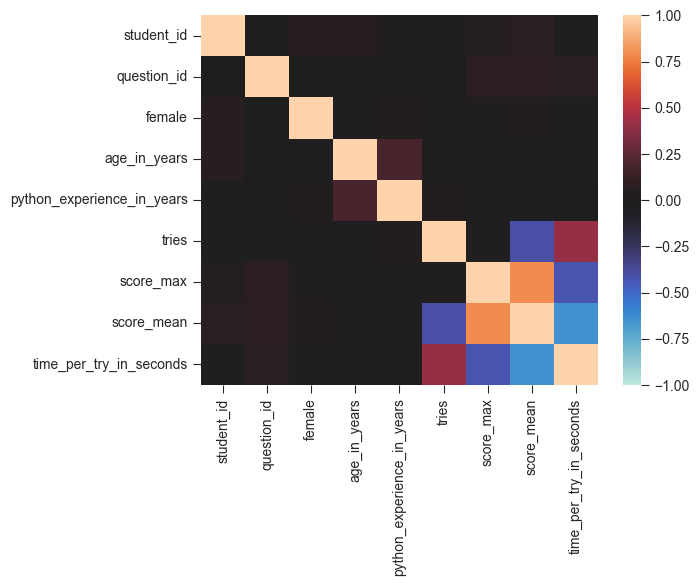

In [12]:
sns.heatmap(data_pq.corr(),vmin=-1,vmax=1,cmap="icefire")

From the heatmap above, we can see that: 
 1. Obviously student id and question id have 0 correlation with anything
 2. It seems that gender, age and Python experience also have no correlation with the rest
 3. However, age and Python experience seem to be slightly correlated (the older the person is, the more they have Python experience)
 3. Maximum score and number of tries have 0 correlation with each other
 4. Otherwise tries, score_max, score_mean and time_per_try have high positive and negative correlations.

### Gender differences
Just to confirm that there are no huge differences in the features between the genders, lets plot kernel density estimates for each (basically a smooth histogram/distribution)

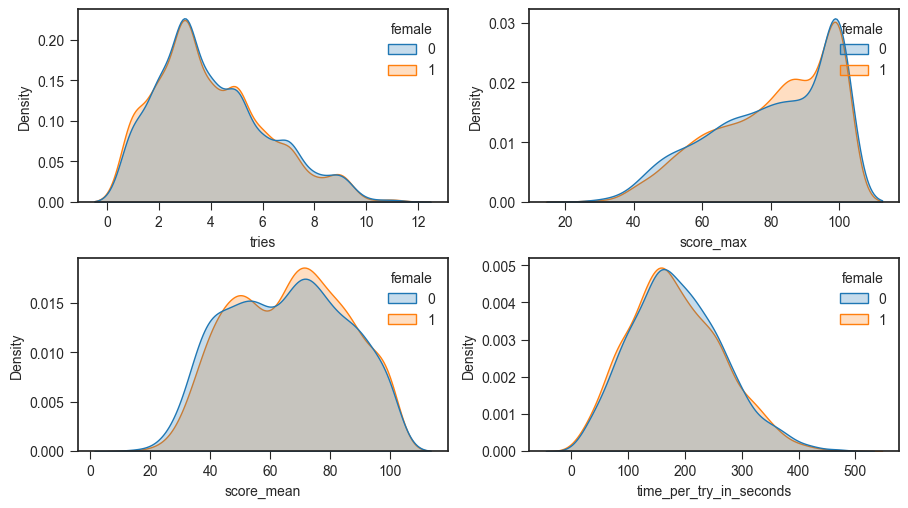

In [13]:
labels = ["tries","score_max","score_mean","time_per_try_in_seconds"]
fig, axes = plt.subplots(figsize=(9, 5) , nrows = 2, ncols = 2)
for i, col in enumerate(labels):
    ax = axes[i // 2][i % 2]
    # common_norm to normalize data since there are slightly more males
    sns.kdeplot(x = col, data = data_pq, ax = ax, hue="female", fill=True, common_norm=False)
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=0.7)

There seems to be almost no difference between the genders.

### Question analysis

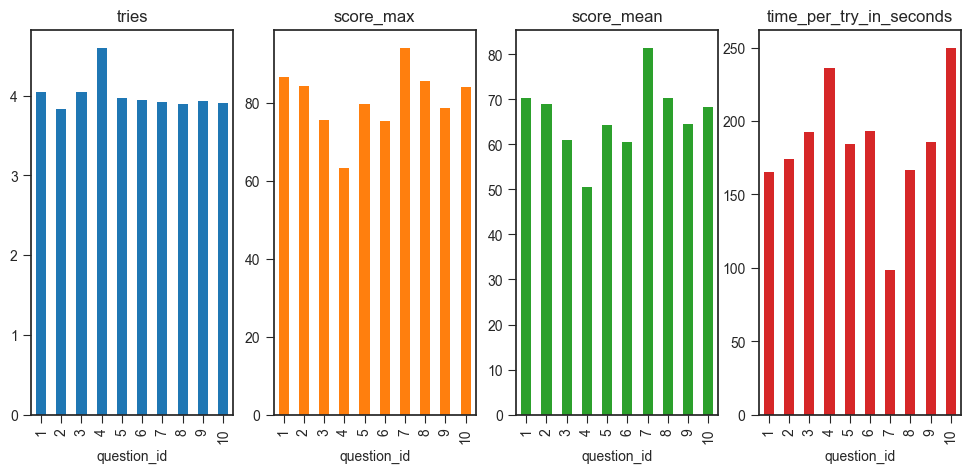

In [14]:
# Plot average tries, score_max, score_mean and time_per_try_in_seconds per question
_ = data_pq.groupby("question_id")[labels].mean().plot(kind="bar",subplots=True, layout=(1,4),figsize=(12,5), legend=False)

From the above plots we can see that there are some differences between the questions.
 1. On average, people seemed to try the question 4 more than other questions.
 2. Question 4 probably was a difficult question, since people got lower max and mean scores from that question
 3. Question 7 seemed short and easy, since students got higher scores from it.
 4. Students spent the longest time on questions 4 and 10, and shortest time on question 7.

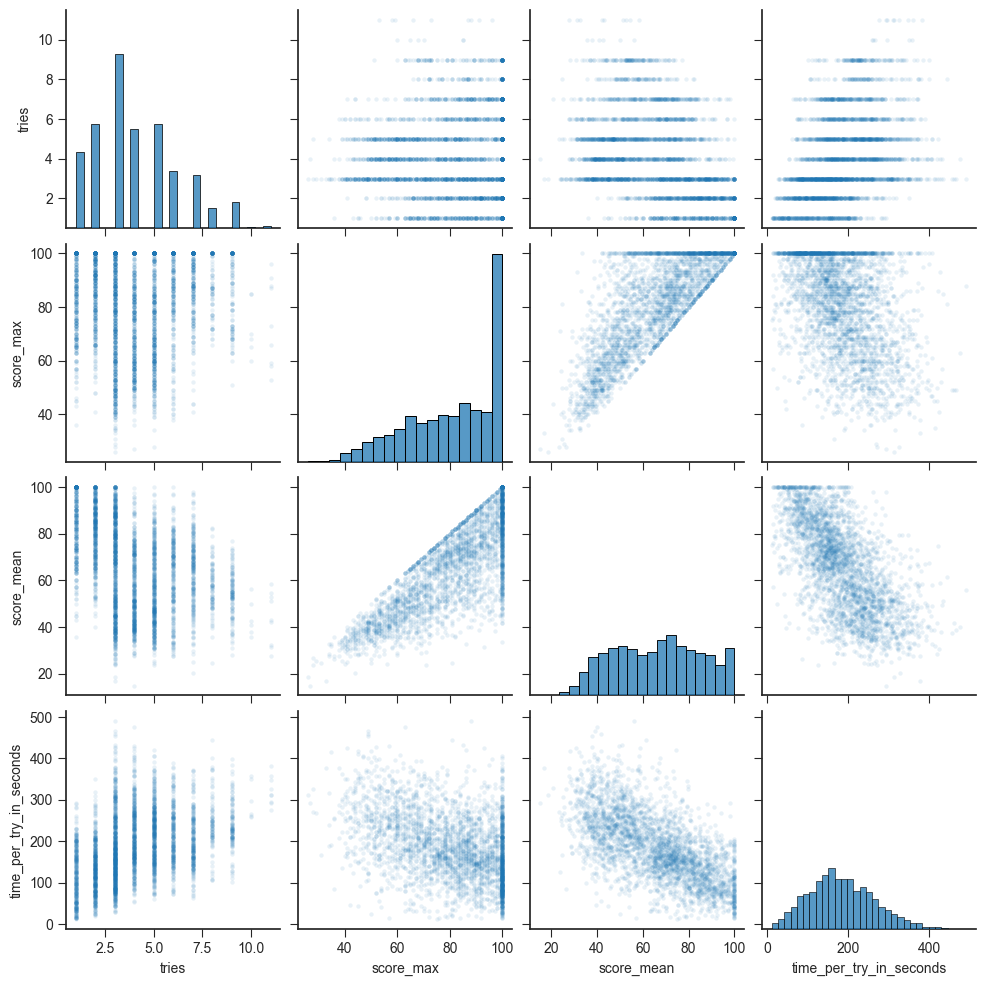

In [15]:
sns.pairplot(data_pq[labels], plot_kws=dict(s=10,edgecolor=None, linewidth=0, alpha=0.1))

From the pairplot we can see the distributions of each feature and how they might correlate with each other. Some observations:
1. Many stuednts got max score of 10. Either the exam was really easy, those students were talented or they just tried enough times until they got the max score and continued.
2. There seems to be a slightly negative trend between the score_mean and tries, meaning that low performing students couldn't increase their scores even if they tried many times.
3. There is a clear negative trend of how much time the student used per try and what was the max/mean score. The longer time they used, the lower score they got, resulting in similar observation than the previous part.

In [18]:
%%time
# Grouping data per student
grouped_ps = data_pq.groupby("student_id")
data_ps = pd.DataFrame()

# Grade (from 0 to 10) is total score / 100, since 1000 is max points
data_ps["grade"] = grouped_ps["score_max"].sum()/100
data_ps[["score_mean","tries_mean"]] = grouped_ps.mean()[["score_mean","tries"]]
data_ps["time_per_try_in_seconds"] = grouped_ps["time_per_try_in_seconds"].sum() / data_pq.groupby("student_id")["question_id"].count()
data_ps[["female","age_in_years","python_experience_in_years"]] = grouped_ps.first()[["female","age_in_years","python_experience_in_years"]]
data_ps

CPU times: total: 15.6 ms
Wall time: 7.5 ms


,grade,score_mean,tries_mean,time_per_try_in_seconds,female,age_in_years,python_experience_in_years
student_id,,,,,,,
1025,8.32,57.279398,6.9,255.554149,1,24,1
1034,9.01,75.344048,5.3,153.273810,0,20,2
1093,8.02,51.323304,6.5,244.901136,0,23,1
1138,7.62,49.607500,5.2,242.895833,1,23,1
1150,9.03,82.533333,2.0,112.116667,0,20,3
...,...,...,...,...,...,...,...
9924,8.70,75.368333,3.8,159.319524,1,27,3
9972,9.06,73.053810,5.4,171.998571,1,24,4
9978,8.71,54.635635,5.9,252.898333,0,21,3


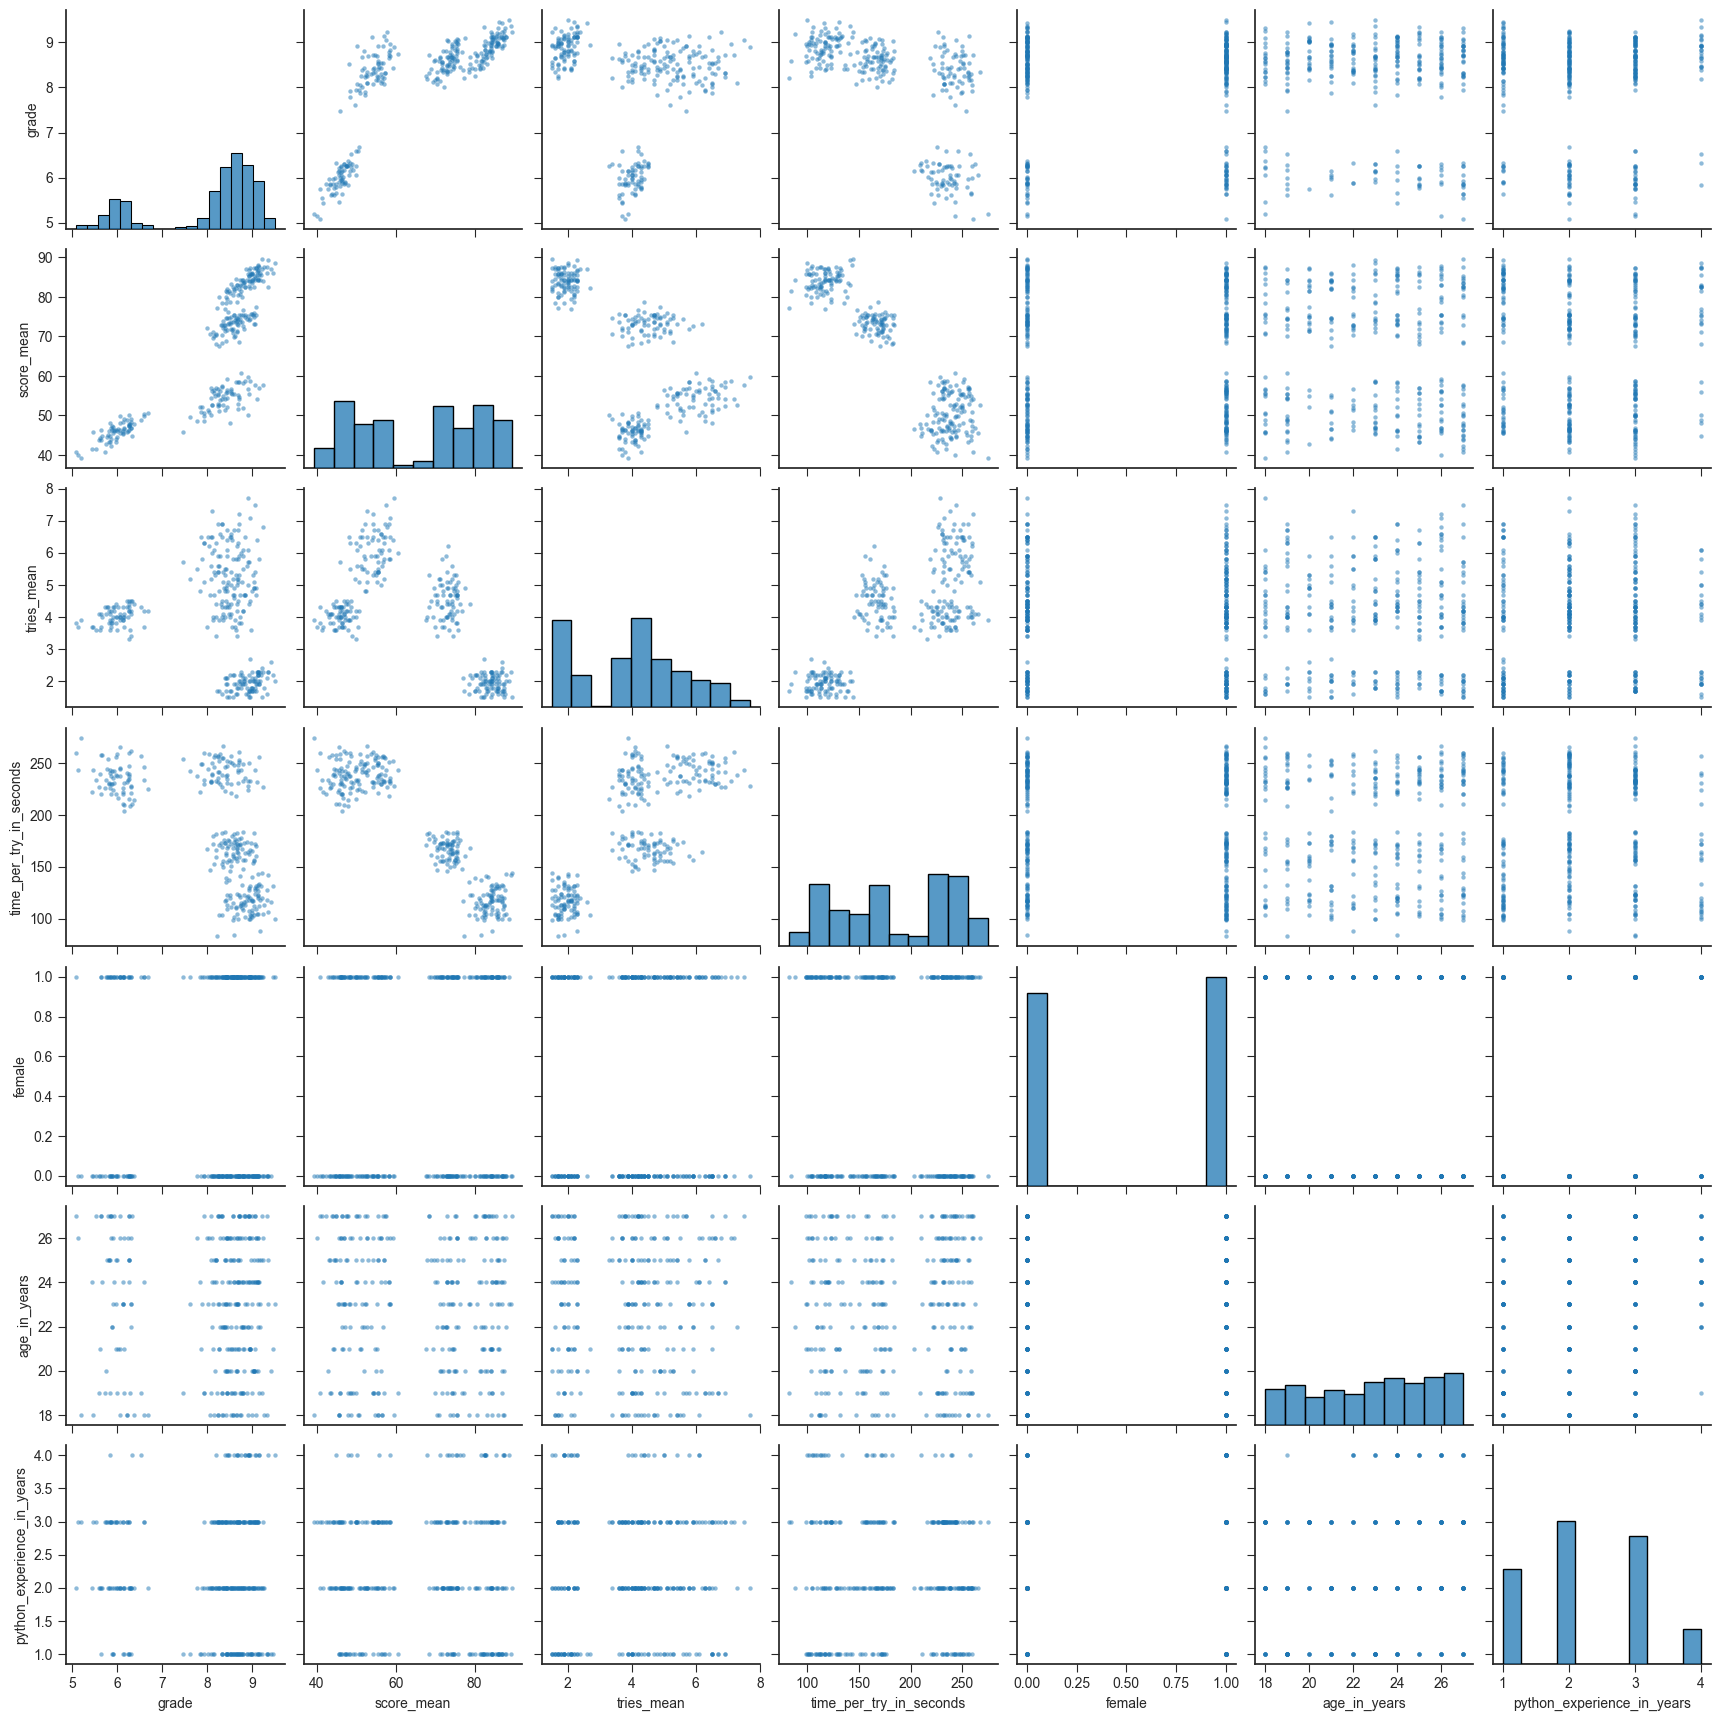

In [19]:
sns.pairplot(data_ps, plot_kws=dict(s=10,edgecolor=None, linewidth=0, alpha=0.5))

From the pairplot we can clearly see that there are some clear groups (clusters) in the first four features. The last three features (female, age and Python experience) shows no correlation with the other features, meaning that maybe the exam was so easy it didn't really matter if you had 1 or 4 years of Python experience. 

Let's try to find out the best way to group the students.

## Unsupervised learning
KMeans is a common clustering method that tries to separate the data into clusters, and grouping all the observations to their nearest cluster. Since the method calculates distances, we should normalize our data with StandardScaler. In addition, in order to visually plot the separate clusters, we can use Principle component analysis (PCA) to represent the data in 2D graph.

In [20]:
# Let's drop the columns without correlation. Including them affects the clustering negatively.
X = data_ps.drop(["age_in_years","female","python_experience_in_years"],1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

# See how much information is lost with PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {round(sum(pca.explained_variance_ratio_)*100,2)}%")

[0.74684624 0.22683774]
Total explained variance: 97.37%


Since we only have 4 features, PCA works surprisingly well, retaining 97% of the information in two vectors.

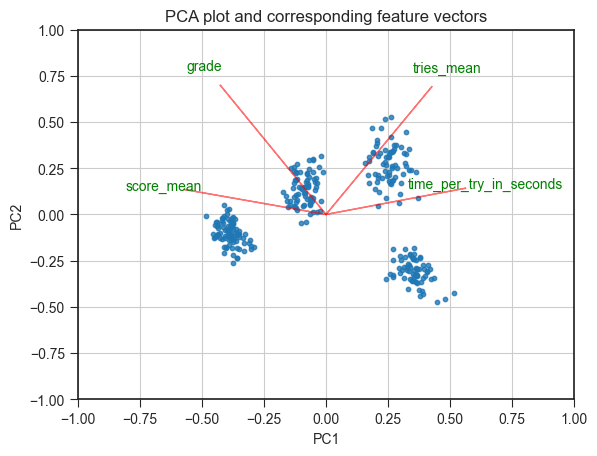

In [21]:
# Plot the PCA-transformed data
# Also plot how the individual features affected the components and to which direction
# Clever piece of code from Seralouk
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697
X_r = pca.fit(X_scaled).transform(X_scaled)
plt.figure()

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=10,alpha=0.8)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title('PCA plot and corresponding feature vectors') 
plt.grid()

#Call the function. 
myplot(X_r[:,0:2], pca.components_.T,labels=X.columns) 

From this scatterplot we can clearly see 4 clusters. In addition, we can see that the four features don't line up, meaning they all have some unique information. That's also probably why PCA reduction worked so well.

Next, even though the scatterplot shows quite clearly 4 clusters, let's try to use different number of clusters in our KMeans-algorithm and calculate the silhouette score for each fit. The silhouette score tells us how well the clusters are separated from each other and how little overlap there is. Scores close to 1 are perfectly separated clusters, scores close to 0 mean full overlap.

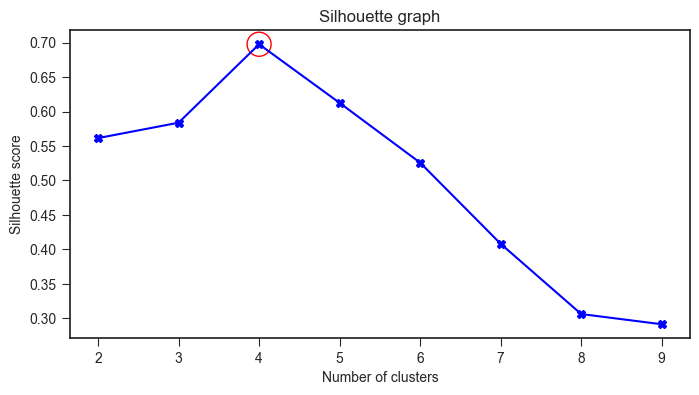

Best number of clusters is 4


In [22]:
# silhouette score
plt.figure(figsize=(8,4))

scores=[]
r = range(2,10)
for i in r:
    y_pred = KMeans(n_clusters=i).fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled,y_pred))
    
plt.plot(r,scores,'bX-')
best_num_of_clusters = 2+scores.index(max(scores))
plt.scatter(best_num_of_clusters, max(scores), edgecolors='r',facecolors='none', s=300)
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette graph') 
plt.show()
print(f"Best number of clusters is {best_num_of_clusters}")

Text(0.5, 1.0, 'PCA plot and clusters found by KMeans')

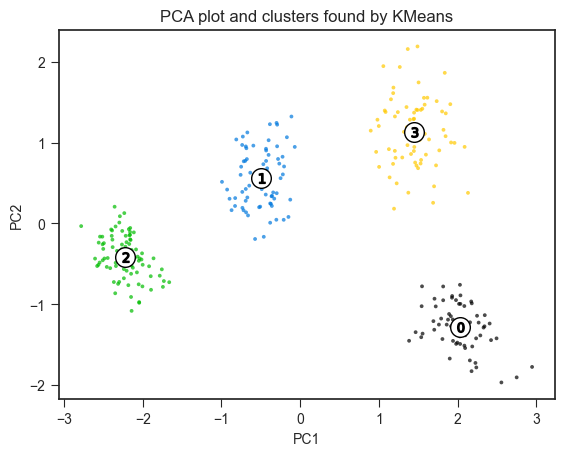

In [23]:
# Let's plot the 4 clusters
# Help got from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

clusterer = KMeans(n_clusters=best_num_of_clusters)
cluster_labels = clusterer.fit_predict(X_r)

colors = cm.nipy_spectral(cluster_labels.astype(float) / best_num_of_clusters)
plt.scatter(
    X_r[:, 0], X_r[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

centers = clusterer.cluster_centers_

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title('PCA plot and clusters found by KMeans') 

In [24]:
# Add labels to data so that we can analyse their differences
X_clusters = data_ps.copy()
X_clusters["cluster"] = cluster_labels+1
X_clusters

,grade,score_mean,tries_mean,time_per_try_in_seconds,female,age_in_years,python_experience_in_years,cluster
student_id,,,,,,,,
1025,8.32,57.279398,6.9,255.554149,1,24,1,4
1034,9.01,75.344048,5.3,153.273810,0,20,2,2
1093,8.02,51.323304,6.5,244.901136,0,23,1,4
1138,7.62,49.607500,5.2,242.895833,1,23,1,4
1150,9.03,82.533333,2.0,112.116667,0,20,3,3
...,...,...,...,...,...,...,...,...
9924,8.70,75.368333,3.8,159.319524,1,27,3,2
9972,9.06,73.053810,5.4,171.998571,1,24,4,2
9978,8.71,54.635635,5.9,252.898333,0,21,3,4


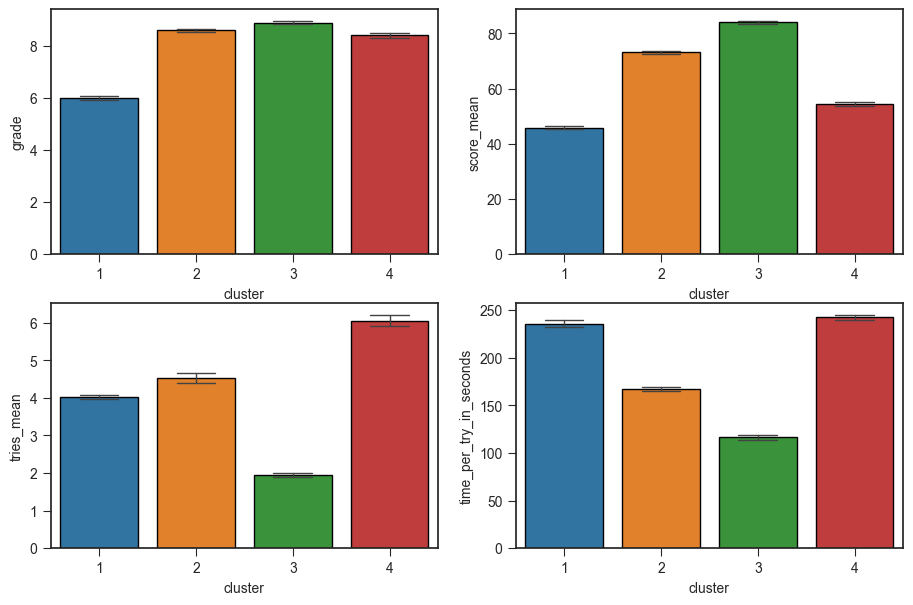

In [25]:
labels = ["grade","score_mean","tries_mean","time_per_try_in_seconds"]
fig, axes = plt.subplots(figsize=(11, 7) , nrows = 2, ncols = 2)
for i,col in enumerate(labels):
    ax = axes[i // 2][i % 2]
    sns.barplot(x="cluster", y=col, data=X_clusters, ax=ax, capsize=.4,edgecolor="0",errwidth=1)

The final four groups have the following behaviours:
 - Cluster 1: Failing students. Spent a long time per question, tried questions several times. Ended up with lowest scores.
 - Cluster 2: Good students. Got high scores, tried each question several times but didn't spend much time in each question.
 - Cluster 3: Talented students. Got the highest scores with least amount of time and tries spent on the questions. 
 - Cluster 4: Hard-working students who spent the longest time on each question and tried the most times. Got good grades in the end. 